# Intro
In this analysis we are looking into Loop Finance ([https://www.loop.markets/](https://www.loop.markets/)) Liquidity Pool (LP) providers and their participation across multiple pools. The main focus is to understand for each LP what the mean, median and mode number of pools a provider would participate in at the same time.

## Data
The Liquidity Pool provider data was obtain from FlipsideCrypto and exported in the `Loop_Liquidity-LP_positions.csv` file so it can be analysed in this notebook using Python.

**Query**: FlipsideCrypto SQL query used to obtain the data can be found in the `lp_positions_query.sql` file.

The resulting table contains a list of providers, LPs and the current LP Token balance. The data is aggregated by provider and LP so each observation (row) represents a provider's position in a pool.

_**Caveats**: The table also contains instances where the provider removed some or most liquidity and remained with very small amounts of LP Tokens. These instances might result in slightly skewed results, but it can be addressed by setting a `balance` threshold below which a position is no longer considered active or taken into account._

### Importing modules and data
We will be importing a few modules needed to wrangle, analyse and plot the data in the code block below.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sp

Now we can import the LP positions data from the `Loop_Liquidity-LP_positions.csv` file and turn it into a Pandas Dataframe.

In [2]:
df = pd.read_csv('Loop_Liquidity-LP_positions.csv')
df.columns = ['provider','lp','provided','withdrawn','balance']
df.head()

,provider,lp,provided,withdrawn,balance
0,terra1pjuxv3u4akau8y25c7d6q0p66k2naauzn0sf6p,loop-ust,28121002749,17000000000,11121002749
1,terra1aqp2yeh8e42fsmm7dq5qhcusmn8lt5yss8vy65,loop-aust,402273968,402273000,968
2,terra1r3rkwnpjtlztj4kskcfku7latzsv5g8turze66,loop-ust,41362520,41362000,520
3,terra1jlc7sshfuknyme9rx3kd72wcym8r2s5sf57vj4,loop-ust,138955149,138955000,149
4,terra1vcmjyvme0qvpx27ctsksp7tvq4u7sl00nhkn6n,loop-ust,17357132,17357000,132


With the data we obtained we can see that we will be analysing **24,501 unique providers** across **37 unique LPs**.

In [3]:
print('Unique providers:',df.provider.nunique())
print('Unique LPs:',df.lp.nunique())

Unique providers: 24501
Unique LPs: 37


Before we break down the data by Liquidity Pool, we will first see how it looks overall.

On average, a provider will have a position in only one LP, with the exact average being 1.44, and this remains true for the majority of them as even over the 75th percentile they generally provide liquidity to only one pool.

However, there are a few outliers with a LP count of over 10, with the biggest one participating in 25 pools.

In [4]:
provider_group = df.groupby(['provider']).count().reset_index()
provider_group.drop(columns=['provided','withdrawn','balance'], inplace=True)
provider_group.columns = ['provider','lp_count']
provider_group.describe()

,lp_count
count,24501.000000
mean,1.447696
std,1.113740
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,25.000000


In the histogram below we can see that the distribution is unimodal and has a heavy skew to the right, with the median and mode values to the left of the mean and overlapping eachother.

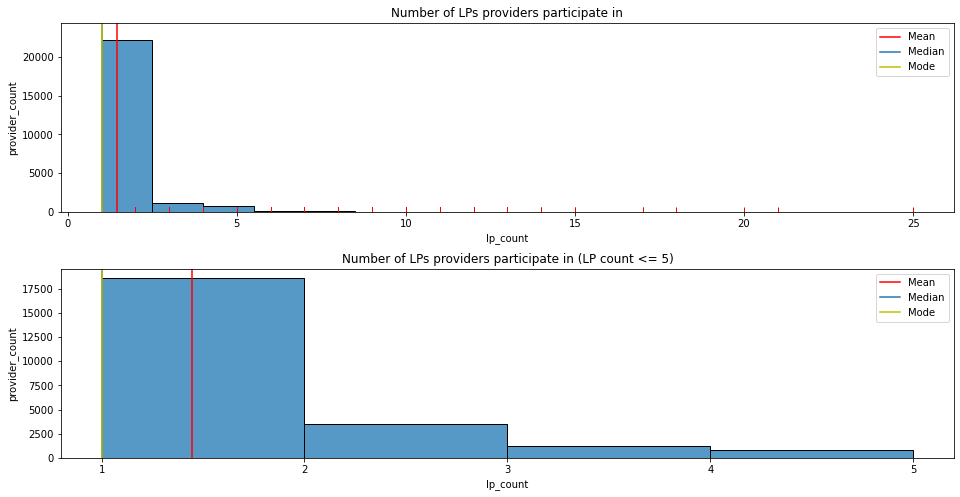

In [5]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot(2,1,1)
sns.histplot(data=provider_group.lp_count)
sns.rugplot(data=provider_group.lp_count, color='r')
plt.axvline(np.mean(provider_group.lp_count), label='Mean', color='r')
plt.axvline(np.median(provider_group.lp_count), label='Median')
plt.axvline(sp.mode(provider_group.lp_count)[0][0], label='Mode', color='y')
plt.title('Number of LPs providers participate in')
plt.ylabel('provider_count')
plt.legend()

ax2 = plt.subplot(2,1,2)
sns.histplot(data=provider_group[provider_group.lp_count <= 5].lp_count, bins=4)
ax2.set_xticks(range(1,6))
plt.title('Number of LPs providers participate in (LP count <= 5)')
plt.ylabel('provider_count')
plt.axvline(np.mean(provider_group.lp_count), label='Mean', color='r')
plt.axvline(np.median(provider_group.lp_count), label='Median')
plt.axvline(sp.mode(provider_group.lp_count)[0][0], label='Mode', color = 'y')

plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()

Then we loop through each LP and for each provider in it we count in how many other pools it is present in. The results are then collected in a python dictionary with the pool name as the key for each entry.

In [6]:
participation_count = {}
for pool in df.lp.unique():
    count = [] # each number indicates in how many pools each provider is in
    for address in df[df.lp == pool].provider.unique():
        in_pools = len(df[df.provider == address])
        if in_pools == 0:
            pass
        else:
            count.append(in_pools)
    participation_count[pool] = count

Once we have the counts, we can loop through the dictionary to calculate the **mean**, **median** and **mode** of participation for each pool.

In [7]:
pools = participation_count.keys()
mean = [round(np.mean(counts),2) for counts in participation_count.values()] # rounding can be removed for increased precision
print(mean)
median = [np.median(counts) for counts in participation_count.values()]
print(median)
mode = [sp.mode(counts)[0][0] for counts in participation_count.values()]
print(mode)

[1.45, 3.86, 2.32, 2.14, 3.5, 3.99, 4.19, 3.66, 2.62, 3.65, 2.66, 5.61, 3.43, 3.08, 4.89, 3.43, 4.76, 4.97, 4.6, 5.81, 3.83, 2.91, 4.0, 4.0, 5.23, 5.38, 3.87, 5.77, 4.75, 6.64, 4.54, 8.23, 6.21, 6.0, 5.41, 4.0, 12.17]
[1.0, 3.0, 2.0, 1.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 2.0, 5.0, 3.0, 2.0, 4.0, 3.0, 4.0, 4.0, 3.0, 5.0, 3.0, 2.0, 3.0, 3.0, 4.0, 5.0, 3.0, 5.0, 3.5, 6.0, 2.0, 9.0, 6.0, 4.0, 5.0, 3.0, 11.0]
[1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 4, 2, 1, 5, 1, 3, 2, 3, 4, 1, 1, 1, 2, 2, 5, 1, 2, 1, 2, 2, 2, 5, 2, 5, 1, 8]


Then we bring all the data together in a Pandas Dataframe so we can plot it using Seaborn.

In [8]:
aggregated = pd.DataFrame(list(zip(pools,mean,median,mode)), columns=['pool','mean','median','mode'])
aggregated.head()

,pool,mean,median,mode
0,loop-ust,1.45,1.0,1
1,loop-aust,3.86,3.0,2
2,bluna-luna,2.32,2.0,1
3,aust-ust,2.14,1.0,1
4,loop-luna,3.50,3.0,2


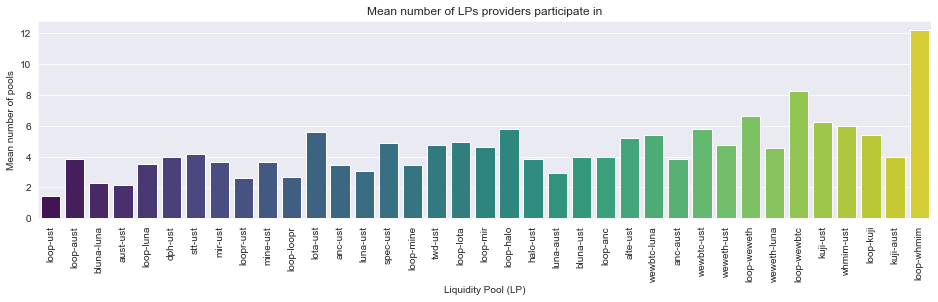

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize=(16,8))
ax = plt.subplot(2,1,1)
sns.barplot(data=aggregated,x='pool',y='mean',palette='viridis')
plt.xticks(rotation=90)
plt.title('Mean number of LPs providers participate in')
plt.xlabel('Liquidity Pool (LP)')
plt.ylabel('Mean number of pools')
plt.show()

As we can observe in the graph above, the mean number of pools a provider participates in can vary widely, from 1 in loop-ust to 12 in loop-whmim.

In [10]:
aggregated[(aggregated['mean'] == aggregated['mean'].max()) | (aggregated['mean'] == aggregated['mean'].min())]

,pool,mean,median,mode
0,loop-ust,1.45,1.0,1
36,loop-whmim,12.17,11.0,8


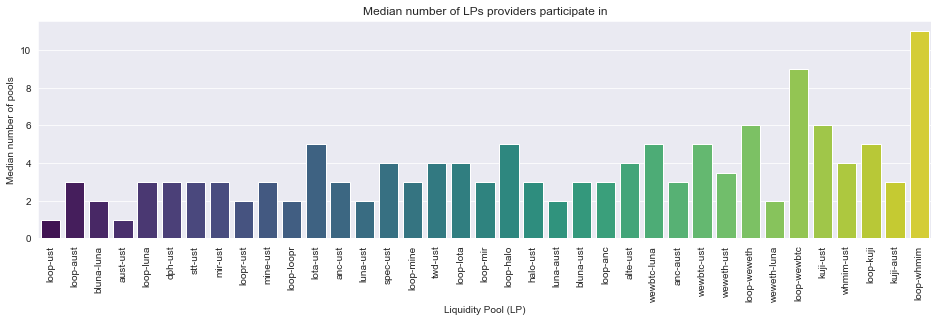

In [11]:
plt.figure(figsize=(16,4))
ax = plt.subplot()
sns.barplot(data=aggregated,x='pool',y='median',palette='viridis')
plt.xticks(rotation=90)
plt.title('Median number of LPs providers participate in')
plt.xlabel('Liquidity Pool (LP)')
plt.ylabel('Median number of pools')
plt.show()

The same variance can also be seen when it comes to the median number of LPs a provider participates in, where we have a couple of pools with a value of just 1 like loop-ust and aust-ust, and going up to 11 in the case of loop-whmim.

In [12]:
aggregated[(aggregated['median'] == aggregated['median'].max()) | (aggregated['median'] == aggregated['median'].min())]

,pool,mean,median,mode
0,loop-ust,1.45,1.0,1
3,aust-ust,2.14,1.0,1
36,loop-whmim,12.17,11.0,8


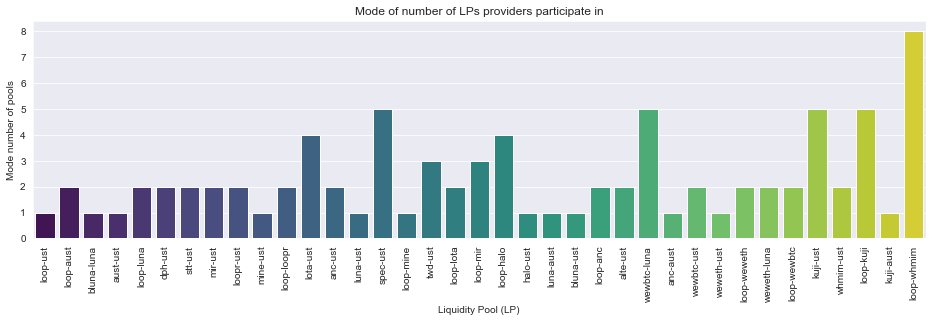

In [13]:
plt.figure(figsize=(16,4))
ax = plt.subplot()
sns.barplot(data=aggregated,x='pool',y='mode',palette='viridis')
plt.xticks(rotation=90)
plt.title('Mode of number of LPs providers participate in')
plt.xlabel('Liquidity Pool (LP)')
plt.ylabel('Mode number of pools')
plt.show()

When it comes to mode, it is most common for a provider to have open positions on only one LP, as we can observe this in 12 of Loop Finance's pools. But then we also have the loop-whmim pool where the most common observation is of providers who are involved in 8 pools at the same time.

In [14]:
aggregated[(aggregated['mode'] == aggregated['mode'].max()) | (aggregated['mode'] == aggregated['mode'].min())]\
    .sort_values(by=['mode'])

,pool,mean,median,mode
0,loop-ust,1.45,1.0,1
2,bluna-luna,2.32,2.0,1
3,aust-ust,2.14,1.0,1
9,mine-ust,3.65,3.0,1
13,luna-ust,3.08,2.0,1
15,loop-mine,3.43,3.0,1
20,halo-ust,3.83,3.0,1
21,luna-aust,2.91,2.0,1
22,bluna-ust,4.00,3.0,1
26,anc-aust,3.87,3.0,1
